A quick example of how to use the lenstronomy code to simulate some strong gravitational lensing with substructure

In [1]:
import numpy as np
import scipy
import os
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import lenstronomy.Util.util as util
import lenstronomy.Util.image_util as image_util

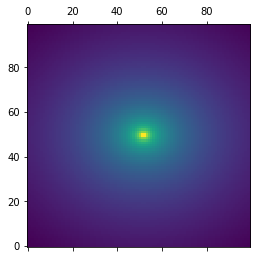

In [22]:
# First we want to specify the halo type. We'll start with something simple like the SIE with external shear, 
# but in practice we'll probably want to at least assume PEMD with external shear (that way we don't overestimate our
# ability to extract a substructure signal).

main_halo_type = 'SIE' 
kwargs_lens_main = {'theta_E': 1., 'e1': 0.1, 'e2': 0, 'center_x': 0.1, 'center_y': 0}
kwargs_shear = {'gamma1': 0.05, 'gamma2': 0}
lens_model_list = [main_halo_type, 'SHEAR']
kwargs_lens_list = [kwargs_lens_main, kwargs_shear]

# Now we need to decide how we'll add subhalos and what those subhalos will look like. We'll start with NFW, and
# we'll 
subhalo_type = 'TNFW'

num_subhalo = 10  # number of subhalos to be rendered
# the parameterization of the NFW profiles are:
# - Rs (radius of the scale parameter Rs in units of angles)
# - theta_Rs (radial deflection angle at Rs)
# - center_x, center_y, (position of the centre of the profile in angular units)

Rs_mean = 0.1 
Rs_sigma = 0.1  # dex scatter
theta_Rs_mean = 0.05 
theta_Rs_sigma = 0.1 # dex scatter
r_min, r_max = -2, 2 # The range in arcseonds of substructure

# This needs to be changed to something more realistic. So far, all we're doing is populating the subhalos randomly
# in the main halo within a certain box.
Rs_list = 10**(np.log10(Rs_mean) + np.random.normal(loc=0, scale=Rs_sigma, size=num_subhalo))
theta_Rs_list = 10**(np.log10(theta_Rs_mean) + np.random.normal(loc=0, scale=theta_Rs_sigma, size=num_subhalo))
center_x_list = np.random.uniform(low=r_min, high=r_max,size=num_subhalo)
center_y_list = np.random.uniform(low=r_min, high=r_max,size=num_subhalo)

# Add all the subhalos to the lens model list
# for i in range(num_subhalo):
#     lens_model_list.append(subhalo_type)
#     kwargs_lens_list.append({'alpha_Rs': theta_Rs_list[i], 'Rs': Rs_list[i],
#                              'center_x': center_x_list[i], 'center_y': center_y_list[i],
#                             'r_trunc': 5*Rs_list[i]
#                             })

# now we define a LensModel class of all the lens models combined
from lenstronomy.LensModel.lens_model import LensModel
lensModel = LensModel(lens_model_list)

# we set up a grid in coordinates and evaluate basic lensing quantities on it
x_grid, y_grid = util.make_grid(numPix=100, deltapix=0.05)
kappa = lensModel.kappa(x_grid, y_grid, kwargs_lens_list)

# we make a 2d array out of the 1d grid points
kappa = util.array2image(kappa)

# and plot the convergence of the lens model
plt.matshow(np.log10(kappa), origin='lower')
plt.show()

In [23]:
# Now we create the lens and source g
z_lens = 0.5
z_source = 2

# Select a cosmology we're going to render our images at.
from astropy.cosmology import default_cosmology
cosmo = default_cosmology.get()

from lenstronomy.Cosmo.lens_cosmo import LensCosmo
# class that converts angular to physical units for a specific cosmology and redshift configuration
lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)

# here we turn an NFW halo defined as M200 crit and concentration into lensing quantities
M200 = 10**9
concentration = 6
Rs_angle_clump, theta_Rs_clump = lensCosmo.nfw_physical2angle(M=M200, c=concentration)
print(Rs_angle_clump, theta_Rs_clump)

# and here we do the oposite and turn the lensing quantities into physical units
rho0_clump, Rs_clump, c_clump, r200_clump, M200_clump = lensCosmo.nfw_angle2physical(Rs_angle_clump, theta_Rs_clump)
print(rho0_clump, Rs_clump, c_clump, r200_clump, M200_clump)

0.37255112041538674 0.0030109052246176976
5684756856491732.0 0.002342687671617255 6.0 0.01405612602970353 1000000000.0000004


In [24]:
# import NGC1300 jpg image and decompose it
import imageio

ngc_filename = os.path.join('ngc1300.jpg')
# read data, this only works if you execute this notebook within the environment of the github repo!
ngc_data = imageio.imread(ngc_filename, as_gray=True, pilmode=None)

# subtract the median of an edge of the image
median = np.median(ngc_data[:200, :200])
ngc_data -= median

# resize the image to square size (add zeros at the edges of the non-square bits of the image)
nx, ny = np.shape(ngc_data)
n_min = min(nx, ny)
n_max = max(nx, ny)
ngc_square = np.zeros((n_max, n_max))
x_start = int((n_max - nx)/2.)
y_start = int((n_max - ny)/2.)
ngc_square[x_start:x_start+nx, y_start:y_start+ny] = ngc_data

# we slightly convolve the image with a Gaussian convolution kernel of a few pixels (optional)
sigma = 5
ngc_conv = scipy.ndimage.filters.gaussian_filter(ngc_square, sigma, mode='nearest', truncate=6)

# we now degrate the pixel resoluton by a factor.
# This reduces the data volume and increases the spead of the Shapelet decomposition
factor = 25  # lower resolution of image with a given factor
numPix_large = int(len(ngc_conv)/factor)
n_new = int((numPix_large-1)*factor)
ngc_cut = ngc_conv[0:n_new,0:n_new]
x, y = util.make_grid(numPix=numPix_large-1, deltapix=1)  # make a coordinate grid
ngc_data_resized = image_util.re_size(ngc_cut, factor)  # re-size image to lower resolution

# now we come to the Shapelet decomposition
# we turn the image in a single 1d array
image_1d = util.image2array(ngc_data_resized)  # map 2d image in 1d data array

11476 number of coefficients


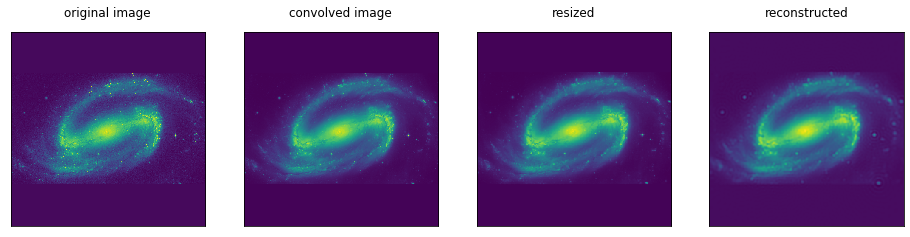

In [25]:
# we define the shapelet basis set we want the image to decompose in
n_max = 150  # choice of number of shapelet basis functions, 150 is a high resolution number, but takes long
beta = 10  # shapelet scale parameter (in units of resized pixels)

# import the ShapeletSet class
from lenstronomy.LightModel.Profiles.shapelets import ShapeletSet
shapeletSet = ShapeletSet()

# decompose image and return the shapelet coefficients
coeff_ngc = shapeletSet.decomposition(image_1d, x, y, n_max, beta, 1., center_x=0, center_y=0) 
print(len(coeff_ngc), 'number of coefficients')  # number of coefficients

# reconstruct NGC1300 with the shapelet coefficients
image_reconstructed = shapeletSet.function(x, y, coeff_ngc, n_max, beta, center_x=0, center_y=0)
# turn 1d array back into 2d image
image_reconstructed_2d = util.array2image(image_reconstructed)  # map 1d data vector in 2d image

f, axes = plt.subplots(1, 4, figsize=(16, 4), sharex=False, sharey=False)

ax = axes[0]
im = ax.matshow(ngc_square, origin='lower')
ax.set_title("original image")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[1]
im = ax.matshow(ngc_conv, origin='lower')
ax.set_title("convolved image")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[2]
im = ax.matshow(ngc_data_resized, origin='lower')
ax.set_title("resized")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[3]
im = ax.matshow(image_reconstructed_2d, origin='lower')
ax.set_title("reconstructed")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()

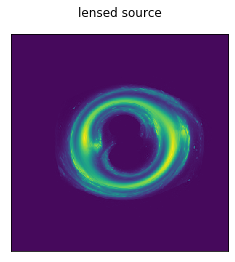

In [26]:
# we define a very high resolution grid for the ray-tracing (needs to be checked to be accurate enough!)
numPix = 100  # number of pixels (low res of data)
deltaPix = 0.05  # pixel size (low res of data)
high_res_factor = 3  # higher resolution factor (per axis)
# make the high resolution grid 
theta_x_high_res, theta_y_high_res = util.make_grid(numPix=numPix*high_res_factor, deltapix=deltaPix/high_res_factor)
# ray-shoot the image plane coordinates (angles) to the source plane (angles)
beta_x_high_res, beta_y_high_res = lensModel.ray_shooting(theta_x_high_res, theta_y_high_res, kwargs=kwargs_lens_list)

# now we do the same as in Section 2, we just evaluate the shapelet functions in the new coordinate system of the source plane
# Attention, now the units are not pixels but angles! So we have to define the size and position.
# This is simply by chosing a beta (Gaussian width of the Shapelets) and a new center

source_lensed = shapeletSet.function(beta_x_high_res, beta_y_high_res, coeff_ngc, n_max, beta=.05, center_x=0.2, center_y=0)
# and turn the 1d vector back into a 2d array
source_lensed = util.array2image(source_lensed)  # map 1d data vector in 2d image

f, ax = plt.subplots(1, 1, figsize=(16, 4), sharex=False, sharey=False)
im = ax.matshow(source_lensed, origin='lower')
ax.set_title("lensed source")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

## Smooth derivatives and potential

If we want to compare a model with and without the subhalos, we don't want to be sensitive to the first order effect of the subhalos adding mass (and therefore increasing the Einstein ring). To do this, we have to get the substructure deflection map, smooth it, and add it back in.

In [27]:
# Make a lens model list that's just the nfw halos.
nfw_model_list = []
kwargs_nfw_lens_list = []
for i in range(num_subhalo):
    nfw_model_list.append(subhalo_type)
    kwargs_nfw_lens_list.append({'alpha_Rs': theta_Rs_list[i], 'Rs': Rs_list[i],
                             'center_x': center_x_list[i], 'center_y': center_y_list[i],
                            'r_trunc': 5*Rs_list[i]
                            })

# Initiate the lens model from the list and get the deflection angle and the hessian
lensModel_temp = LensModel(nfw_model_list)
f = lensModel_temp.potential(x_grid, y_grid,kwargs_nfw_lens_list)
a_x, a_y = lensModel_temp.alpha(x_grid, y_grid, kwargs_nfw_lens_list)
# Multiplane returns the parameters in this order.
f_xx, f_xy, f_yx, f_yy = lensModel_temp.hessian(x_grid, y_grid, kwargs_nfw_lens_list)

# Now we want to smooth things out a bit. Honestly I'm not sure how sound this is mathematically, but I'd love to
# hear from Simon on that.
sigma = 5
f_s = util.array2image(f)- scipy.ndimage.gaussian_filter(util.array2image(f),sigma=sigma)
a_x_s = util.array2image(a_x)-scipy.ndimage.gaussian_filter(util.array2image(a_x),sigma=sigma)
a_y_s = util.array2image(a_y)-scipy.ndimage.gaussian_filter(util.array2image(a_y),sigma=sigma)
f_xx_s = util.array2image(f_xx)-scipy.ndimage.gaussian_filter(util.array2image(f_xx),sigma=sigma)
f_yy_s = util.array2image(f_yy)-scipy.ndimage.gaussian_filter(util.array2image(f_yy),sigma=sigma)
f_xy_s = util.array2image(f_xy)-scipy.ndimage.gaussian_filter(util.array2image(f_xy),sigma=sigma)

# Now we build a new model with an interpol class with these arguments
main_halo_type = 'SIE' 
kwargs_lens_main = {'theta_E': 1., 'e1': 0.1, 'e2': 0, 'center_x': 0.1, 'center_y': 0}
kwargs_shear = {'gamma1': 0.05, 'gamma2': 0}
lens_model_list = [main_halo_type, 'SHEAR']
kwargs_lens_list_smooth = [kwargs_lens_main, kwargs_shear]

lens_model_list.append('INTERPOL')
x_axes, y_axes = util.get_axes(x_grid, y_grid)
kwargs_lens_list_smooth.append({'grid_interp_x':x_axes, 'grid_interp_y':y_axes, 'f_':f_s, 
                         'f_x':a_x_s, 'f_y':a_y_s, 'f_xx':f_xx_s, 'f_yy':f_yy_s, 'f_xy':f_xy_s})

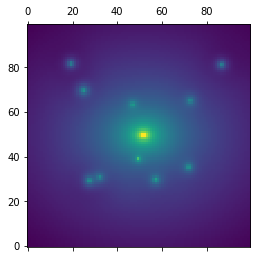

In [29]:
lensModel_smooth = LensModel(lens_model_list)
kappa = lensModel_smooth.kappa(x_grid, y_grid, kwargs_lens_list_smooth)

# we make a 2d array out of the 1d grid points
kappa = util.array2image(kappa)

# and plot the convergence of the lens model
plt.matshow(np.log10(kappa), origin='lower')
plt.show()

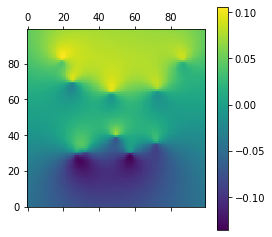

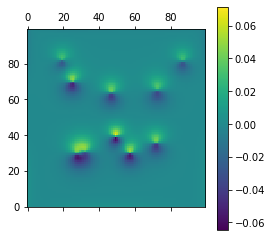

In [30]:
# Just quickly visualize what we're doing to the deflection angle
plt.matshow(util.array2image(a_y), origin='lower')
plt.colorbar()
plt.show()
plt.matshow(a_y_s, origin='lower')
plt.colorbar()
plt.show()

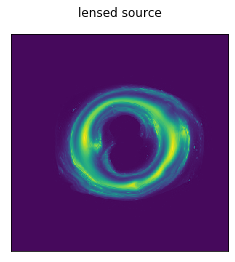

In [31]:
theta_x_high_res, theta_y_high_res = util.make_grid(numPix=numPix*high_res_factor, deltapix=deltaPix/high_res_factor)
# ray-shoot the image plane coordinates (angles) to the source plane (angles)
beta_x_high_res, beta_y_high_res = lensModel_smooth.ray_shooting(theta_x_high_res, theta_y_high_res, 
                                                                 kwargs=kwargs_lens_list_smooth)

# now we do the same as in Section 2, we just evaluate the shapelet functions in the new coordinate system of the source plane
# Attention, now the units are not pixels but angles! So we have to define the size and position.
# This is simply by chosing a beta (Gaussian width of the Shapelets) and a new center

source_lensed_smooth = shapeletSet.function(beta_x_high_res, beta_y_high_res, coeff_ngc, n_max, beta=.05, center_x=0.2, center_y=0)
# and turn the 1d vector back into a 2d array
source_lensed_smooth = util.array2image(source_lensed_smooth)  # map 1d data vector in 2d image

f, ax = plt.subplots(1, 1, figsize=(16, 4), sharex=False, sharey=False)
im = ax.matshow(source_lensed_smooth, origin='lower')
ax.set_title("lensed source")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

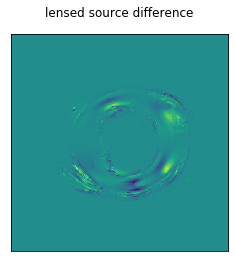

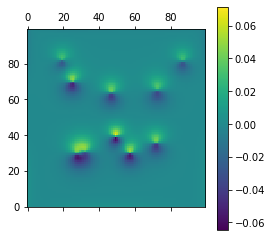

In [33]:
# show the difference between the two images
f, ax = plt.subplots(1, 1, figsize=(16, 4), sharex=False, sharey=False)
im = ax.matshow(source_lensed-source_lensed_smooth, origin='lower')
ax.set_title("lensed source difference")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

plt.matshow(a_y_s, origin='lower')
plt.colorbar()
plt.show()